<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue"></span> Model Training</h1>
<hr>



In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Scikit-Learn for Modeling
import sklearn

# Pickle for saving model files
import pickle

In [2]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split # Scikit-Learn 0.18+

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# For standardization
from sklearn.preprocessing import StandardScaler

# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

In [4]:
## Load analytical base table from Module 2
df = pd.read_csv('analytical_base_table.csv')

<span id="split"></span>
# 1. Split your dataset


In [5]:
# Create separate object for target variable
y = df.status

# Create separate object for input features
X = df.drop('status', axis=1)

In [6]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

11254 2814 11254 2814


<span id="pipelines"></span>
# 2. Build model pipelines



In [7]:
# Pipeline dictionary
pipelines = {
    'l1' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l1' , random_state=123)),
    'l2' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l2' , random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

<span id="hyperparameters"></span>
# 3. Declare hyperparameters to tune


In [8]:
# List tuneable hyperparameters of our Logistic pipeline
pipelines['l1'].get_params()

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__n_jobs': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 123,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': Tru

Let's declare the **hyperparameter grids** to tune.

In [9]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

**Declare the hyperparameter grid for the random forest.**

In [10]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

**Declare the hyperparameter grid for the boosted tree.**

In [11]:
# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [12]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

<span id="fit-tune"></span>
# 4. Fit and tune models with cross-validation


In [13]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.') 


l1 has been fitted.
l2 has been fitted.
rf has been fitted.
gb has been fitted.


<span id="evaluate"></span>
# 5. Evaluate metrics


In [14]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.8510751732717257
l2 0.8510751732717257
rf 0.9802736804691665
gb 0.9776968189088324


<span id="auroc"></span>
# 6. Area under ROC curve



In [20]:
# Classification metrics
from sklearn.metrics import roc_curve, auc

In [21]:
# Predict classes using L1-regularized logistic regression 
pred = fitted_models['l1'].predict(X_test)

# Display first 10 predictions
pred[:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 0], dtype=int64)

In [22]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[ 432  241]
 [ 191 1950]]


In [17]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l1'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
pred[:10]

[0.5398455976091763,
 0.3820106979308769,
 0.667187663671884,
 0.9362944119367398,
 0.9729748169065645,
 0.8249465029943069,
 0.4800794023409641,
 0.3223877134460816,
 0.6521427851075392,
 0.2910752087238851]

In [23]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

In [24]:
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame({'FPR': fpr, 'TPR' : tpr, 'Thresholds' : thresholds}).tail(10)

,FPR,TPR,Thresholds
0,0.000000,0.000000,2
1,0.358098,0.910789,1
2,1.000000,1.000000,0


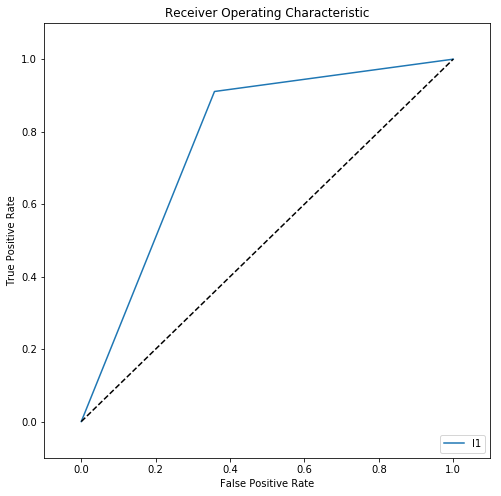

In [25]:
# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Calculate AUROC
print( auc(fpr, tpr) )

0.7763456412099996


In [27]:
# Code here
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print( name, auc(fpr, tpr) )

l1 0.8906032578407974
l2 0.8906039518548565
rf 0.9879623261408029
gb 0.9857692417132987


In [28]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)